In [1]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 49.0 MB/s eta 0:00:0000:01:00:01


In [6]:
import pandas as pd

df = pd.read_csv('/kaggle/input/wikiart-gangogh-creating-art-gan/WikiArt.csv')
df

,image_path,class_name,labels
0,/kaggle/input/wikiart-gangogh-creating-art-gan...,genre-painting,6
1,/kaggle/input/wikiart-gangogh-creating-art-gan...,genre-painting,6
2,/kaggle/input/wikiart-gangogh-creating-art-gan...,genre-painting,6
3,/kaggle/input/wikiart-gangogh-creating-art-gan...,genre-painting,6
4,/kaggle/input/wikiart-gangogh-creating-art-gan...,genre-painting,6
...,...,...,...
96009,/kaggle/input/wikiart-gangogh-creating-art-gan...,landscape,7
96010,/kaggle/input/wikiart-gangogh-creating-art-gan...,landscape,7
96011,/kaggle/input/wikiart-gangogh-creating-art-gan...,landscape,7
96012,/kaggle/input/wikiart-gangogh-creating-art-gan...,landscape,7


In [12]:
df['image_path'][2]

'/kaggle/input/wikiart-gangogh-creating-art-gan/genre-painting/7beec20949e87f3b1cdad0467a334c80c.jpg'

In [13]:
df2 = pd.read_csv('/kaggle/input/wikiart/classes.csv')
df2[df2['phash'] == '7beec20949e87f3b1cdad0467a334c80c']

,filename,artist,genre,description,phash,width,height,genre_count,subset


In [83]:
import numpy as np
import torch
from tqdm import tqdm
from PIL import Image

In [84]:
image_folder = '/kaggle/input/wikiart'
with open('/kaggle/input/metadata-retrieval-v2/images.txt', 'r') as file:
    image_paths = [line.strip() for line in file]
for i in range(len(image_paths)):
    image_paths[i] = image_folder + "/" + "/".join(image_paths[i].split("\\")[1:])

In [85]:
with open('/kaggle/input/metadata-retrieval-v2/metadata.txt', 'r') as file:
    metadata = [line.strip() for line in file]

In [86]:
with open('/kaggle/input/description-image/all_prompts.txt', 'r') as file:
    prompts = [line.strip() for line in file]

In [87]:
image_caption_labels = []
for i in range(len(metadata)):
    image_caption_labels.append(" ".join(metadata[i].split(" in the style of ")[:-1]))
    
image_artist_labels = []
for i in range(len(image_paths)):
    image_artist_labels.append(" ".join(image_paths[i].split("/")[-1].split("_")[0].split("-")))
    
image_genre_labels = []
for i in range(len(metadata)):
    image_genre_labels.append(metadata[i].split(" in the style of ")[-1])
    
info = []
for i in range(len(image_caption_labels)):
    info.append([image_caption_labels[i], image_artist_labels[i], image_genre_labels[i]])

In [88]:
style_name = {
    140: 'Abstract Expressionism', 141: 'Action Painting', 142: 'Analytical Cubism',
    143: 'Art Nouveau', 144: 'Baroque', 145: 'Color Field Painting',
    146: 'Contemporary Realism', 147: 'Cubism', 148: 'Early Renaissance',
    149: 'Expressionism', 150: 'Fauvism', 151: 'High Renaissance',
    152: 'Impressionism', 153: 'Mannerism Late Renaissance', 154: 'Minimalism',
    155: 'Naive Art Primitivism', 156: 'New Realism', 157: 'Northern Renaissance',
    158: 'Pointillism', 159: 'Pop Art', 160: 'Post Impressionism', 161: 'Realism',
    162: 'Rococo', 163: 'Romanticism', 164: 'Symbolism', 165: 'Synthetic Cubism',
    166: 'Ukiyo-e'
}

In [89]:
from pathlib import Path
import pandas as pd

image_folder = '/kaggle/input/wikiart'
metadata_path2 = Path(image_folder)/'wclasses.csv'
df = pd.read_csv(metadata_path2)

In [90]:
images_style = {}
for _id, row in df.iterrows():
    images_style['/kaggle/input/wikiart/' + row['file']] = style_name[row['style']]

In [91]:
images_style_label = []
for path in image_paths:
    if path in images_style:
        images_style_label.append('The style of the image is ' + images_style[path])
    else:
        images_style_label.append('')

In [92]:
# len(images_style_label)

In [93]:
# import pickle

# with open('WikiArt_images_style.pkl','wb') as f:
#     pickle.dump(images_style_label, f)

In [94]:
# with open('/kaggle/working/WikiArt_images_style.pkl', 'rb') as file:
#     data = pickle.load(file)

In [95]:
# data

In [96]:
# images_style_label[0]

In [97]:
artist_name = {
    0: 'Unknown Artist', 1: 'Boris Kustodiev', 2: 'Camille Pissarro', 3: 'Childe Hassam', 
    4: 'Claude Monet', 5: 'Edgar Degas', 6: 'Eugene Boudin', 7: 'Gustave Dore', 
    8: 'Ilya Repin', 9: 'Ivan Aivazovsky', 10: 'Ivan Shishkin', 11: 'John Singer Sargent', 
    12: 'Marc Chagall', 13: 'Martiros Saryan', 14: 'Nicholas Roerich', 15: 'Pablo Picasso', 
    16: 'Paul Cezanne', 17: 'Pierre Auguste Renoir', 18: 'Pyotr Konchalovsky', 
    19: 'Raphael Kirchner', 20: 'Rembrandt', 21: 'Salvador Dali', 22: 'Vincent Van Gogh', 
    23: 'Hieronymus Bosch', 24: 'Leonardo Da Vinci', 25: 'Albrecht Durer', 
    26: 'Edouard Cortes', 27: 'Sam Francis', 28: 'Juan Gris', 29: 'Lucas Cranach The Elder', 
    30: 'Paul Gauguin', 31: 'Konstantin Makovsky', 32: 'Egon Schiele', 33: 'Thomas Eakins', 
    34: 'Gustave Moreau', 35: 'Francisco Goya', 36: 'Edvard Munch', 37: 'Henri Matisse', 
    38: 'Fra Angelico', 39: 'Maxime Maufra', 40: 'Jan Matejko', 41: 'Mstislav Dobuzhinsky', 
    42: 'Alfred Sisley', 43: 'Mary Cassatt', 44: 'Gustave Loiseau', 45: 'Fernando Botero', 
    46: 'Zinaida Serebriakova', 47: 'Georges Seurat', 48: 'Isaac Levitan', 49: 'Joaquín Sorolla', 
    50: 'Jacek Malczewski', 51: 'Berthe Morisot', 52: 'Andy Warhol', 53: 'Arkhip Kuindzhi', 
    54: 'Niko Pirosmani', 55: 'James Tissot', 56: 'Vasily Polenov', 57: 'Valentin Serov', 
    58: 'Pietro Perugino', 59: 'Pierre Bonnard', 60: 'Ferdinand Hodler', 
    61: 'Bartolome Esteban Murillo', 62: 'Giovanni Boldini', 63: 'Henri Martin', 
    64: 'Gustav Klimt', 65: 'Vasily Perov', 66: 'Odilon Redon', 67: 'Tintoretto', 
    68: 'Gene Davis', 69: 'Raphael', 70: 'John Henry Twachtman', 71: 'Henri De Toulouse Lautrec', 
    72: 'Antoine Blanchard', 73: 'David Burliuk', 74: 'Camille Corot', 75: 'Konstantin Korovin', 
    76: 'Ivan Bilibin', 77: 'Titian', 78: 'Maurice Prendergast', 79: 'Edouard Manet', 
    80: 'Peter Paul Rubens', 81: 'Aubrey Beardsley', 82: 'Paolo Veronese', 
    83: 'Joshua Reynolds', 84: 'Kuzma Petrov Vodkin', 85: 'Gustave Caillebotte', 
    86: 'Lucian Freud', 87: 'Michelangelo', 88: 'Dante Gabriel Rossetti', 89: 'Felix Vallotton', 
    90: 'Nikolay Bogdanov Belsky', 91: 'Georges Braque', 92: 'Vasily Surikov', 
    93: 'Fernand Leger', 94: 'Konstantin Somov', 95: 'Katsushika Hokusai', 
    96: 'Sir Lawrence Alma Tadema', 97: 'Vasily Vereshchagin', 98: 'Ernst Ludwig Kirchner', 
    99: 'Mikhail Vrubel', 100: 'Orest Kiprensky', 101: 'William Merritt Chase', 
    102: 'Aleksey Savrasov', 103: 'Hans Memling', 104: 'Amedeo Modigliani', 
    105: 'Ivan Kramskoy', 106: 'Utagawa Kuniyoshi', 107: 'Gustave Courbet', 
    108: 'William Turner', 109: 'Theo Van Rysselberghe', 110: 'Joseph Wright', 
    111: 'Edward Burne Jones', 112: 'Koloman Moser', 113: 'Viktor Vasnetsov', 
    114: 'Anthony Van Dyck', 115: 'Raoul Dufy', 116: 'Frans Hals', 
    117: 'Hans Holbein The Younger', 118: 'Ilya Mashkov', 119: 'Henri Fantin Latour', 
    120: 'M.C. Escher', 121: 'El Greco', 122: 'Mikalojus Ciurlionis', 
    123: 'James Mcneill Whistler', 124: 'Karl Bryullov', 125: 'Jacob Jordaens', 
    126: 'Thomas Gainsborough', 127: 'Eugene Delacroix', 128: 'Canaletto'
}

In [98]:
images_artist = {}
for _id, row in df.iterrows():
    images_artist['/kaggle/input/wikiart/' + row['file']] = artist_name[row['artist']]

In [99]:
# images_artist

In [100]:
images_artist_label = []
for path in image_paths:
    if path in images_artist:
        images_artist_label.append('The artist of the image is ' + images_artist[path])
    else:
        images_artist_label.append('')

In [101]:
images_artist_label[40:50]

['The artist of the image is Sam Francis',
 'The artist of the image is Sam Francis',
 'The artist of the image is Sam Francis',
 'The artist of the image is Sam Francis',
 'The artist of the image is Sam Francis',
 'The artist of the image is Sam Francis',
 'The artist of the image is Sam Francis',
 'The artist of the image is Sam Francis',
 'The artist of the image is Sam Francis',
 'The artist of the image is Sam Francis']

In [102]:
# An image in the style of Post-Impressionism by Vincent van Gogh.

In [103]:
images_style_artist = {}
for _id, row in df.iterrows():
    images_style_artist['/kaggle/input/wikiart/' + row['file']] = 'An image in the style of ' + style_name[row['style']] + ' by ' + artist_name[row['artist']]

In [104]:
images_style_artist_label = []
for path in image_paths:
    if path in images_style_artist:
        images_style_artist_label.append(images_style_artist[path])
    else:
        images_style_artist_label.append('')

In [131]:
# images_style_artist_label

In [132]:
# import pickle

# with open('WikiArt_images_style_artist.pkl','wb') as f:
#     pickle.dump(images_style_artist_label, f)

In [109]:
from transformers import pipeline
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

qa_pipeline = pipeline(
    "question-answering",
    model="csarron/bert-base-uncased-squad-v1",
    tokenizer="csarron/bert-base-uncased-squad-v1",
    device = device
)

In [110]:
!pip install salesforce-lavis

In [111]:
from lavis.models import load_model_and_preprocess
import torch
from transformers import BertTokenizer
import torch.nn.functional as F

def init_model(model_size = 'pretrain'): #model_size must be "pretrain"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, vis_processors, txt_processors = load_model_and_preprocess(name = "blip2_feature_extractor", 
                                                                          model_type = model_size, 
                                                                          is_eval = True, 
                                                                          device = device)
    return model, vis_processors, txt_processors

def init_tokenizer(): 
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    tokenizer.add_special_tokens({"bos_token": "[DEC]"})
    tokenizer.add_special_tokens({"additional_special_tokens": ["[ENC]"]})
    tokenizer.enc_token_id = tokenizer.additional_special_tokens_ids[0]
    return tokenizer

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, vis_processors, txt_processors = init_model('pretrain_vitL')#pretrain, pretrain_vitL, coco
tokenizer = init_tokenizer()

In [12]:
# model.Qformer

In [27]:
# from transformers import BertTokenizer, BertModel

# tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
# model_bert = BertModel.from_pretrained('bert-base-uncased').to(device)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Embedding texts, images and prompts

In [113]:
def image_encoder(image, model, vis_processors, device):
    image_processed = vis_processors["eval"](img).unsqueeze(0).to(device)
    with model.maybe_autocast():
        image_embeds = model.ln_vision(model.visual_encoder(image_processed))
    image_embeds = image_embeds.float()
    image_atts = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(
                image_embeds.device
            )
    query_tokens = model.query_tokens.expand(image_embeds.shape[0], -1, -1)

    query_output = model.Qformer.bert(
                        query_embeds=query_tokens,
                        encoder_hidden_states=image_embeds,
                        encoder_attention_mask=image_atts,
                        return_dict=True,
                    )
    image_feats = F.normalize(model.vision_proj(query_output.last_hidden_state), dim=-1)
  
    return image_feats[0][0].detach().cpu().numpy()

def text_encoder(text, model, tokenizer, text_processors, device):
    text_input = text_processors["eval"](text)
    text = tokenizer(text_input, return_tensors="pt", padding=True).to(device)
    text_output = model.Qformer.bert(
                text.input_ids,
                attention_mask=text.attention_mask,
                return_dict=True,
            )
    text_feat = F.normalize(
                model.text_proj(text_output.last_hidden_state[:, 0, :]), dim=-1
            )
    return text_feat[0].detach().cpu().numpy()

## Image embedding

In [11]:
img = Image.open(image_paths[0])
img_emb = image_encoder(img, model, vis_processors, device)
img_emb.shape

(256,)

In [27]:
# images_embedding = []

# for path in tqdm(image_paths):
#     img = Image.open(path)
#     style_index = df[df['file'] == path.replace("/kaggle/input/wikiart/", "")]['style'].values
#     style_text = ""
#     if len(style_index) > 0:
#         style_text = name_style[style_index[0]]
    
#     artist_index = df[df['file'] == path.replace("/kaggle/input/wikiart/", "")]['artist'].values
#     artist_name = ""
#     if len(artist_index) > 0:
#         artist_name = name_artist[artist_index[0]]
        
#     img_emb = image_encoder(img, style_text, artist_name, model, vis_processors, model_bert, tokenizer_bert, device) # size (256,)
#     images_embedding.append(img_emb)
#     break

# images_embedding = np.array(images_embedding)
# print(images_embedding.shape)

In [ ]:
import pickle

with open('WikiArt_images_embeddings.pkl','wb') as f:
    pickle.dump(images_embedding, f)

In [ ]:
import pickle

with open('WikiArt_images_embeddings.pkl','wb') as f:
    pickle.dump(images_embedding, f)

In [ ]:
texts_embedding = None

for text in tqdm(metadata):
    text_input = txt_processors["eval"](text)
    sample = {"text_input": [text_input]}

    text_emb = model.extract_features(sample, mode="text").text_embeds[:,0,:] # size (1, 768)

    # stack tensor
    if texts_embedding is None:
        texts_embedding = text_emb
    else:
        texts_embedding = torch.cat((texts_embedding, text_emb),0)

print('texts_embedding.size(): ', texts_embedding.size())

In [ ]:
prompts_embedding = None

for prompt in tqdm(prompts):
    prompt_input = txt_processors["eval"](prompt)
    sample = {"text_input": [prompt_input]}

    prompt_emb = model.extract_features(sample, mode="text").text_embeds[:,0,:] # size (1, 768)

    # stack tensor
    if prompts_embedding is None:
        prompts_embedding = prompt_emb
    else:
        prompts_embedding = torch.cat((prompts_embedding, prompt_emb),0)

print('texts_embedding.size(): ', prompts_embedding.size())

In [ ]:
# images_embedding /= images_embedding.norm(dim=-1, keepdim=True)
# texts_embedding /= texts_embedding.norm(dim=-1, keepdim=True)
# prompts_embedding /= prompts_embedding.norm(dim=-1, keepdim=True)

In [ ]:
import pickle

with open('WikiArt_prompts_embeddings.pkl','wb') as f:
    pickle.dump(prompts_embedding, f)

# Load data embedding

In [114]:
import pickle
with open('/kaggle/input/embedding-pretrainvitl/WikiArt_texts_embedding.pkl', 'rb') as fp:
    texts_embedding = pickle.load(fp)
    
with open('/kaggle/input/embedding-pretrainvitl/WikiArt_images_embeddings.pkl', 'rb') as fp:
    images_embedding = pickle.load(fp)
    
with open('/kaggle/input/embedding-pretrainvitl/WikiArt_prompts_embedding.pkl', 'rb') as fp:
    prompts_embedding = pickle.load(fp)
    
with open('/kaggle/input/artist-style/WikiArt_artists_embedding.pkl', 'rb') as fp:
    artists_embedding = pickle.load(fp)
    
with open('/kaggle/input/artist-style/WikiArt_styles_embedding.pkl', 'rb') as fp:
    styles_embedding = pickle.load(fp)
    
with open('/kaggle/input/artist-style/WikiArt_style_artist_embedding.pkl', 'rb') as fp:
    style_artist_embedding = pickle.load(fp)

In [21]:
artists_embedding.shape

(63443, 256)

In [22]:
# texts_embedding = texts_embedding.detach().cpu().numpy()
# images_embedding = images_embedding.detach().cpu().numpy()
# prompts_embedding = prompts_embedding.detach().cpu().numpy()

In [115]:
images_embedding = torch.from_numpy(images_embedding).to(device)
artists_embedding = torch.from_numpy(artists_embedding).to(device)
styles_embedding = torch.from_numpy(styles_embedding).to(device)

In [60]:
artists_embedding[0].shape

(256,)

In [116]:
alpha = 1
beta = 1
gamma = 1
weights_vector = torch.tensor([gamma, beta, alpha], dtype=torch.float32).to(device)
# weights_vector[0]
vector_embedding = None

for i in tqdm(range(texts_embedding.shape[0])):
#     concat_matrix = torch.cat((weights_vector[0] * images_embedding[i].view(1, -1), weights_vector[1] * artists_embedding[i].view(1, -1), weights_vector[2] * styles_embedding[i].view(1, -1)), dim = 1)
#     res = weights_vector @ concat_matrix
    concat_matrix = torch.cat((weights_vector[0] * images_embedding[i].view(1, -1), weights_vector[1] * artists_embedding[i].view(1, -1), weights_vector[2] * styles_embedding[i].view(1, -1)), dim = 1)
    
    if vector_embedding is None:
        vector_embedding = concat_matrix
    else:
        vector_embedding = torch.cat((vector_embedding, concat_matrix), dim = 0)

100%|██████████| 63443/63443 [01:01<00:00, 1029.06it/s]


In [23]:
vector_embedding.shape

torch.Size([63443, 768])

# Indexing

In [117]:
import faiss

# Indexing images

In [118]:
images_index = faiss.IndexFlatIP(images_embedding.shape[1])
images_index.add(images_embedding.detach().cpu().numpy())
# images_index.add(images_embedding)

# Indexing texts

In [18]:
texts_index = faiss.IndexFlatIP(texts_embedding.shape[1])
texts_index.add(texts_embedding)

# Indexing prompts

In [49]:
prompts_index = faiss.IndexFlatIP(prompts_embedding.shape[1])
prompts_index.add(prompts_embedding)

# Indexing vector embedding

In [119]:
vector_index = faiss.IndexFlatIP(vector_embedding.shape[1])
vector_index.add(vector_embedding.detach().cpu().numpy())

# Indexing artist embedding

In [120]:
artists_index = faiss.IndexFlatIP(artists_embedding.shape[1])
artists_index.add(artists_embedding.detach().cpu().numpy())

# Indexing style embedding

In [121]:
styles_index = faiss.IndexFlatIP(styles_embedding.shape[1])
styles_index.add(styles_embedding.detach().cpu().numpy())

# Indexing style-artist embedding

In [21]:
style_artist_index = faiss.IndexFlatIP(style_artist_embedding.shape[1])
style_artist_index.add(style_artist_embedding)

In [122]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode
from PIL import Image

# function to display product images
def display_result(image_batch, info, labels, width=150, height=100, format='JPEG', quality=85):
    figures = []
    for img, caption, label in zip(image_batch, info, labels):  # Loop through both images and captions
        b = BytesIO()

        # Use LANCZOS resampling
        img.thumbnail((width, height), Image.Resampling.LANCZOS)

        img.save(b, format=format, quality=quality)
        encoded_img = b64encode(b.getvalue()).decode('utf-8')
        figures.append(f'''
          <figure style="margin: 5px !important; text-align: center;">
            <figcaption style="margin-bottom: 5px;">{caption[0]}</figcaption>
            <figcaption style="margin-bottom: 5px;">{caption[1]}</figcaption>
            <figcaption style="margin-bottom: 5px;">{caption[2]}</figcaption>
            <figcaption style="margin-bottom: 5px;">{label}</figcaption>
            <img src="data:image/jpeg;base64,{encoded_img}" style="width: {width}px; height: {height}px" >
          </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; justify-content: center;">
        {''.join(figures)}
        </div>
    ''')

In [ ]:
def get_text_embedding(text_target, is_coco_finetuned = False):

    # preprocess image. check if the image is None. In this case build a tensor with shape (1, 3, 224, 224)
#     if image_target is None:
#         image_processed = torch.rand(1, 3, 364, 364).to(device)
#     else:
#         image_processed = vis_processors["eval"](image_target).unsqueeze(0).to(device)

#     # preprocess text
    text_input = txt_processors["eval"](text_target)

    # build sample
    sample = {"text_input": [text_input]}

    # find features of image and text target
#     multimodal_emb = model.extract_features(sample).multimodal_embeds[0,0,:] # size (768)
#     image_emb = model.extract_features(sample, mode="image").image_embeds[0,0,:] # size (768)
    text_emb = model.extract_features(sample, mode="text").text_embeds[0,0,:] # size (768)

    # normalize
#     image_emb /= image_emb.norm(dim=-1, keepdim=True)
    text_emb /= text_emb.norm(dim=-1, keepdim=True)
#     multimodal_emb /= multimodal_emb.norm(dim=-1, keepdim=True)

    # transform to numpy tensor
#     image_emb = image_emb.cpu().detach().numpy()
    text_emb = text_emb.cpu().detach().numpy()
#     multimodal_emb = multimodal_emb.cpu().detach().numpy()

#     if search_modality == "TI":
#         similarity_vector = images_embedding.cpu().detach().numpy() @ text_emb.T
#     else search_modality == "TM":
#         similarity_vector = multimodal_embedding.cpu().detach().numpy() @ text_emb.T

#     return multimodal_emb
    return text_emb

In [ ]:
# Simple Object Retrieval:
# "Show me images of a red apple."
# "Find pictures of a yellow sunflower."

# Complex Object Retrieval:
# "Retrieve images of a person riding a bicycle on a beach."
# "Find pictures of a cat playing with a ball of yarn."

# Scene Descriptions:
# "Show images of a sunset over a mountain range."
# "Find pictures of a bustling city street at night."

# Specific Situations:
# "Retrieve images of a family having a picnic in a park."
# "Find pictures of a dog running through a field of flowers."

# Artistic Styles:
# "Show me images of abstract paintings with blue and green colors."
# "Find pictures of impressionist paintings of Paris." - vec (prompts)

# Emotional Contexts:
# "Retrieve images that depict happiness and joy."
# "Find pictures that convey a sense of loneliness and isolation."

# Famous Landmarks:
# "Show images of the Eiffel Tower at night."
# "Find pictures of the Great Wall of China in winter."

# Cultural Events:
# "Retrieve images of a traditional Japanese tea ceremony." - vec (image)
# "Find pictures of a carnival parade in Brazil."

# Animals in Action:
# "Show images of dolphins jumping out of the water." - vec 
# "Find pictures of an eagle soaring in the sky."

# Historical Moments:
# "Retrieve images of the moon landing in 1969." - vec (prompt)
# "Find pictures of the fall of the Berlin Wall."

# Food and Cuisine:
# "Show me images of a traditional Italian pizza." - vector
# "Find pictures of a beautifully plated sushi dish." - vector

# Fashion and Style:
# "Retrieve images of a runway fashion show." - vector
# "Find pictures of vintage clothing from the 1920s." - text is better than vec

# Nature and Landscapes:
# "Show images of a serene lake surrounded by trees."
# "Find pictures of a desert landscape at sunrise." - text, prompt is better than vec

# Sports and Activities:
# "Retrieve images of a soccer match in action."
# "Find pictures of people hiking in the mountains." - vec(image)

# Abstract Concepts:
# "Show me images that represent freedom and independence." - vec(image)
# "Find pictures that symbolize love and affection." - vec(text)

In [123]:
import pickle

with open('/kaggle/input/genre-labels/genre_labels.pkl', 'rb') as file:
    genre_labels = pickle.load(file)

with open('/kaggle/input/genre-labels/name_genre.pkl', 'rb') as file:
    genre_name = pickle.load(file)

In [124]:
genre_name[140] = 'Animal'
genre_name[141] = 'Plant'
genre_name[142] = 'Object painting'
genre_name[143] = 'Fruit'

genre_name

{129: 'Abstract Painting',
 130: 'Cityscape',
 131: 'Genre Painting',
 132: 'Illustration',
 133: 'Landscape',
 134: 'Nude painting',
 135: 'Portrait',
 136: 'Religious painting',
 137: 'Sketch And Study',
 138: 'Still life',
 139: 'Unknown Genre',
 140: 'Animal',
 141: 'Plant',
 142: 'Object painting',
 143: 'Fruit'}

In [125]:
import pandas as pd
from PIL import Image
from pathlib import Path

# Assuming the metadata and image paths are in a CSV file
image_folder = '/kaggle/input/wikiart'
metadata_path = Path(image_folder)/'classes.csv'
metadata_path2 = Path(image_folder)/'wclasses.csv'
label_images = '/kaggle/input/label-images/label_images_v2.csv'

In [126]:
df = pd.read_csv(metadata_path2)
replace_df = pd.read_csv(label_images)

replaceDataset_idx = df[df['genre'].isin([137, 138, 139])].index
idx2 = 0
for idx in replaceDataset_idx:
#     print(df.iloc[idx2]['genre'])
    df.loc[idx, 'genre'] = replace_df.iloc[idx2]['genre']
    idx2 += 1
    
for _id, row in df.iterrows():
    genre_labels['/kaggle/input/wikiart/' + row['file']] = row['genre']

In [89]:
cnt = 0
for style in images_artist_label:
    if style.replace('The artist of the image is ', '') == search_text:
        cnt += 1
print(cnt)

1067


In [127]:
# genre_labels

In [47]:
predictions_style = qa_pipeline({
    'context': search_text,
    'question': "What is the style mentioned in the sentence?"
})['answer']

In [48]:
# print(predictions_artist)
print(predictions_style)

dog in the snow


In [75]:
search_text = "portrait"

0.08333826065063477
[(55730, 1.7290066), (55745, 1.754154), (55827, 1.7594562), (55805, 1.7637739), (55739, 1.7725081)]
[55739 55805 55827 55745 55730]



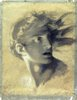
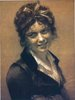
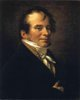
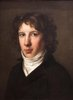
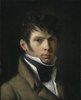

In [128]:
import time

start_time = time.time()
predictions_artist = qa_pipeline({
    'context': search_text,
    'question': "What is the artist mentioned in the sentence?"
})['answer']

predictions_style = qa_pipeline({
    'context': search_text,
    'question': "What is the style mentioned in the sentence?"
})['answer']

# genre_query = 'Plant'
# style_query = 'Realism'
# artist_query = 'Vincent Van Gogh'


# text_search_embedding = text_encoder(genre_query, model, tokenizer, txt_processors, device)
# artist_input_embedding = text_encoder(artist_query, model, tokenizer, txt_processors, device)
# style_input_embedding = text_encoder(style_query, model, tokenizer, txt_processors, device)
# query_search = np.concatenate((text_search_embedding.reshape(1, -1), artist_input_embedding.reshape(1, -1), style_input_embedding.reshape(1, -1)), axis = 1)

#embedding text
text_search_embedding = text_encoder(search_text, model, tokenizer, txt_processors, device)
artist_input_embedding = text_encoder(predictions_artist, model, tokenizer, txt_processors, device)
style_input_embedding = text_encoder(predictions_style, model, tokenizer, txt_processors, device)
query_search = np.concatenate((text_search_embedding.reshape(1, -1), artist_input_embedding.reshape(1, -1), style_input_embedding.reshape(1, -1)), axis = 1)

#search
distances, indices = vector_index.search(query_search, 5)
# distances, indices = images_index.search(text_search_embedding.reshape(1, -1), 5)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

distances = distances[0]
indices = indices[0]

indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1])  # Sort based on the distances

print(indices_distances)
print(indices)

similar_images = [image_paths[idx] for idx in indices ]
caption = [info[idx] for idx in indices]
imgs_dis = [Image.open(similar_images[i]) for i in range(len(similar_images))]
labels = []
for idx in indices:
    if image_paths[idx] in genre_labels:
        labels.append(genre_name[genre_labels[image_paths[idx]]])
    else:
        labels.append('unknown genre')
display_result(imgs_dis, caption, labels)

In [89]:
# evaluation_query

# EVALUATION

In [130]:
def AP_score(k, actual, predicted):
    ap_num = 0
    numOfRel = 0
    
    actual_set = set(actual)
    rel_set = set()
    
    for x in range(min(k, len(predicted))):
        pred_item = predicted[x]
        
        if pred_item in actual_set:
            numOfRel += 1
            rel_set.add(pred_item)
        
        precision_at_k = len(rel_set) / (x + 1)
        
        if pred_item in actual_set:
            ap_num += precision_at_k
    
    if numOfRel == 0:
        return 0
    
    return ap_num / numOfRel

## Evaluating content

In [66]:
import pickle

with open('/kaggle/input/genre-labels/genre_labels.pkl', 'rb') as file:
    genre_labels = pickle.load(file)

with open('/kaggle/input/genre-labels/name_genre.pkl', 'rb') as file:
    genre_name = pickle.load(file)

genre_name[140] = 'Animal'
genre_name[141] = 'Plant'
genre_name[142] = 'Object painting'
genre_name[143] = 'Fruit'

import pandas as pd
from PIL import Image
from pathlib import Path

# Assuming the metadata and image paths are in a CSV file
image_folder = '/kaggle/input/wikiart'
metadata_path = Path(image_folder)/'classes.csv'
metadata_path2 = Path(image_folder)/'wclasses.csv'
label_images = '/kaggle/input/label-images/label_images_v2.csv'

df = pd.read_csv(metadata_path2)
replace_df = pd.read_csv(label_images)

replaceDataset_idx = df[df['genre'].isin([137, 138, 139])].index
idx2 = 0
for idx in replaceDataset_idx:
#     print(df.iloc[idx2]['genre'])
    df.loc[idx, 'genre'] = replace_df.iloc[idx2]['genre']
    idx2 += 1
    
for _id, row in df.iterrows():
    genre_labels['/kaggle/input/wikiart/' + row['file']] = row['genre']

In [83]:
k = 5
mAP = []
image_pos = 0
for search_text in name_genre.values():
    if search_text in ['Nude painting', 'Unknown Genre', 'Sketch And Study', 'Fruit', 'Object painting', 'Genre Painting', 'Illustration']:
        continue
    
    #embedding text
    zeros_array = np.zeros(768)
    text_search_embedding = text_encoder(search_text, model, tokenizer, txt_processors, device)
    zeros_array[image_pos:image_pos + text_search_embedding.shape[0]] = text_search_embedding
#     print(zeros_array)
#     break

    #search
    distances, indices = vector_index.search(zeros_array.reshape(1, -1), k)
#     distances, indices = images_index.search(text_search_embedding.reshape(1, -1), k)
    distances = distances[0]
    indices = indices[0]
    
    actual = []
    for index in indices:
        genre_index = df[df['file'] == image_paths[index].replace("/kaggle/input/wikiart/", "")]['genre'].values
        if len(genre_index) > 0 and name_genre[genre_index[0]] == search_text:
            actual.append(index)
    
    ap_q = AP_score(k, actual, indices)
    mAP.append(ap_q)
    print(f"{search_text}: AP@{k} = {round(ap_q,2)}")
print(f'mAP@{k} = {sum(mAP)/len(mAP)}')

Abstract Painting: AP@5 = 1.0
Cityscape: AP@5 = 1.0
Landscape: AP@5 = 1.0
Portrait: AP@5 = 1.0
Religious painting: AP@5 = 1.0
Still life: AP@5 = 1.0
Animal: AP@5 = 0.92
Plant: AP@5 = 1.0
mAP@5 = 0.9895833333333334


## Evaluating style

In [99]:
style_name = {
    140: 'Abstract Expressionism', 141: 'Action Painting', 142: 'Analytical Cubism',
    143: 'Art Nouveau', 144: 'Baroque', 145: 'Color Field Painting',
    146: 'Contemporary Realism', 147: 'Cubism', 148: 'Early Renaissance',
    149: 'Expressionism', 150: 'Fauvism', 151: 'High Renaissance',
    152: 'Impressionism', 153: 'Mannerism Late Renaissance', 154: 'Minimalism',
    155: 'Naive Art Primitivism', 156: 'New Realism', 157: 'Northern Renaissance',
    158: 'Pointillism', 159: 'Pop Art', 160: 'Post Impressionism', 161: 'Realism',
    162: 'Rococo', 163: 'Romanticism', 164: 'Symbolism', 165: 'Synthetic Cubism',
    166: 'Ukiyo-e'
}

In [84]:
k = 25
mAP = []
style_pos = 256 * 2
for search_text in style_name.values():
    
    #embedding text
    zeros_array = np.zeros(768)
    text_search_embedding = text_encoder(search_text, model, tokenizer, txt_processors, device)
    zeros_array[style_pos:style_pos + text_search_embedding.shape[0]] = text_search_embedding

    #search
    distances, indices = vector_index.search(zeros_array.reshape(1, -1), k)
    distances = distances[0]
    indices = indices[0]
    
    actual = []
    for index in indices:
        style_index = df[df['file'] == image_paths[index].replace("/kaggle/input/wikiart/", "")]['style'].values
        if len(style_index) > 0 and style_name[style_index[0]] == search_text:
            actual.append(index)
    
    ap_q = AP_score(k, actual, indices)
    mAP.append(ap_q)
    print(f"{search_text}: AP@{k} = {round(ap_q,2)}")
print(f'mAP@{k} = {sum(mAP)/len(mAP)}')

Abstract Expressionism: AP@25 = 1.0
Action Painting: AP@25 = 1.0
Analytical Cubism: AP@25 = 1.0
Art Nouveau: AP@25 = 1.0
Baroque: AP@25 = 1.0
Color Field Painting: AP@25 = 1.0
Contemporary Realism: AP@25 = 1.0
Cubism: AP@25 = 1.0
Early Renaissance: AP@25 = 1.0
Expressionism: AP@25 = 1.0
Fauvism: AP@25 = 1.0
High Renaissance: AP@25 = 1.0
Impressionism: AP@25 = 1.0
Mannerism Late Renaissance: AP@25 = 1.0
Minimalism: AP@25 = 1.0
Naive Art Primitivism: AP@25 = 1.0
New Realism: AP@25 = 1.0
Northern Renaissance: AP@25 = 1.0
Pointillism: AP@25 = 1.0
Pop Art: AP@25 = 1.0
Post Impressionism: AP@25 = 1.0
Realism: AP@25 = 1.0
Rococo: AP@25 = 1.0
Romanticism: AP@25 = 1.0
Symbolism: AP@25 = 1.0
Synthetic Cubism: AP@25 = 1.0
Ukiyo-e: AP@25 = 1.0
mAP@25 = 1.0


## Evaluating artist

In [101]:
artist_name = {
    0: 'Unknown Artist', 1: 'Boris Kustodiev', 2: 'Camille Pissarro', 3: 'Childe Hassam', 
    4: 'Claude Monet', 5: 'Edgar Degas', 6: 'Eugene Boudin', 7: 'Gustave Dore', 
    8: 'Ilya Repin', 9: 'Ivan Aivazovsky', 10: 'Ivan Shishkin', 11: 'John Singer Sargent', 
    12: 'Marc Chagall', 13: 'Martiros Saryan', 14: 'Nicholas Roerich', 15: 'Pablo Picasso', 
    16: 'Paul Cezanne', 17: 'Pierre Auguste Renoir', 18: 'Pyotr Konchalovsky', 
    19: 'Raphael Kirchner', 20: 'Rembrandt', 21: 'Salvador Dali', 22: 'Vincent Van Gogh', 
    23: 'Hieronymus Bosch', 24: 'Leonardo Da Vinci', 25: 'Albrecht Durer', 
    26: 'Edouard Cortes', 27: 'Sam Francis', 28: 'Juan Gris', 29: 'Lucas Cranach The Elder', 
    30: 'Paul Gauguin', 31: 'Konstantin Makovsky', 32: 'Egon Schiele', 33: 'Thomas Eakins', 
    34: 'Gustave Moreau', 35: 'Francisco Goya', 36: 'Edvard Munch', 37: 'Henri Matisse', 
    38: 'Fra Angelico', 39: 'Maxime Maufra', 40: 'Jan Matejko', 41: 'Mstislav Dobuzhinsky', 
    42: 'Alfred Sisley', 43: 'Mary Cassatt', 44: 'Gustave Loiseau', 45: 'Fernando Botero', 
    46: 'Zinaida Serebriakova', 47: 'Georges Seurat', 48: 'Isaac Levitan', 49: 'Joaquín Sorolla', 
    50: 'Jacek Malczewski', 51: 'Berthe Morisot', 52: 'Andy Warhol', 53: 'Arkhip Kuindzhi', 
    54: 'Niko Pirosmani', 55: 'James Tissot', 56: 'Vasily Polenov', 57: 'Valentin Serov', 
    58: 'Pietro Perugino', 59: 'Pierre Bonnard', 60: 'Ferdinand Hodler', 
    61: 'Bartolome Esteban Murillo', 62: 'Giovanni Boldini', 63: 'Henri Martin', 
    64: 'Gustav Klimt', 65: 'Vasily Perov', 66: 'Odilon Redon', 67: 'Tintoretto', 
    68: 'Gene Davis', 69: 'Raphael', 70: 'John Henry Twachtman', 71: 'Henri De Toulouse Lautrec', 
    72: 'Antoine Blanchard', 73: 'David Burliuk', 74: 'Camille Corot', 75: 'Konstantin Korovin', 
    76: 'Ivan Bilibin', 77: 'Titian', 78: 'Maurice Prendergast', 79: 'Edouard Manet', 
    80: 'Peter Paul Rubens', 81: 'Aubrey Beardsley', 82: 'Paolo Veronese', 
    83: 'Joshua Reynolds', 84: 'Kuzma Petrov Vodkin', 85: 'Gustave Caillebotte', 
    86: 'Lucian Freud', 87: 'Michelangelo', 88: 'Dante Gabriel Rossetti', 89: 'Felix Vallotton', 
    90: 'Nikolay Bogdanov Belsky', 91: 'Georges Braque', 92: 'Vasily Surikov', 
    93: 'Fernand Leger', 94: 'Konstantin Somov', 95: 'Katsushika Hokusai', 
    96: 'Sir Lawrence Alma Tadema', 97: 'Vasily Vereshchagin', 98: 'Ernst Ludwig Kirchner', 
    99: 'Mikhail Vrubel', 100: 'Orest Kiprensky', 101: 'William Merritt Chase', 
    102: 'Aleksey Savrasov', 103: 'Hans Memling', 104: 'Amedeo Modigliani', 
    105: 'Ivan Kramskoy', 106: 'Utagawa Kuniyoshi', 107: 'Gustave Courbet', 
    108: 'William Turner', 109: 'Theo Van Rysselberghe', 110: 'Joseph Wright', 
    111: 'Edward Burne Jones', 112: 'Koloman Moser', 113: 'Viktor Vasnetsov', 
    114: 'Anthony Van Dyck', 115: 'Raoul Dufy', 116: 'Frans Hals', 
    117: 'Hans Holbein The Younger', 118: 'Ilya Mashkov', 119: 'Henri Fantin Latour', 
    120: 'M.C. Escher', 121: 'El Greco', 122: 'Mikalojus Ciurlionis', 
    123: 'James Mcneill Whistler', 124: 'Karl Bryullov', 125: 'Jacob Jordaens', 
    126: 'Thomas Gainsborough', 127: 'Eugene Delacroix', 128: 'Canaletto'
}

In [85]:
k = 25
mAP = []
artist_pos = 256
for search_text in artist_name.values():
    if search_text in ['Unknown Artist', 'Joaquín Sorolla']:
        continue
    
    #embedding text
    zeros_array = np.zeros(768)
    text_search_embedding = text_encoder(search_text, model, tokenizer, txt_processors, device)
    zeros_array[artist_pos:artist_pos + text_search_embedding.shape[0]] = text_search_embedding

    #search
    distances, indices = artists_index.search(text_search_embedding.reshape(1, -1), k)
    distances = distances[0]
    indices = indices[0]
    
    actual = []
    for index in indices:
        artist_index = df[df['file'] == image_paths[index].replace("/kaggle/input/wikiart/", "")]['artist'].values
        if len(artist_index) > 0 and artist_name[artist_index[0]] == search_text:
            actual.append(index)
    
    ap_q = AP_score(k, actual, indices)
    mAP.append(ap_q)
    print(f"{search_text}: AP@{k} = {round(ap_q,2)}")
print(f'mAP@{k} = {sum(mAP)/len(mAP)}')

Boris Kustodiev: AP@25 = 1.0
Camille Pissarro: AP@25 = 1.0
Childe Hassam: AP@25 = 1.0
Claude Monet: AP@25 = 1.0
Edgar Degas: AP@25 = 1.0
Eugene Boudin: AP@25 = 1.0
Gustave Dore: AP@25 = 1.0
Ilya Repin: AP@25 = 1.0
Ivan Aivazovsky: AP@25 = 1.0
Ivan Shishkin: AP@25 = 1.0
John Singer Sargent: AP@25 = 1.0
Marc Chagall: AP@25 = 1.0
Martiros Saryan: AP@25 = 1.0
Nicholas Roerich: AP@25 = 1.0
Pablo Picasso: AP@25 = 1.0
Paul Cezanne: AP@25 = 1.0
Pierre Auguste Renoir: AP@25 = 1.0
Pyotr Konchalovsky: AP@25 = 1.0
Raphael Kirchner: AP@25 = 1.0
Rembrandt: AP@25 = 1.0
Salvador Dali: AP@25 = 1.0
Vincent Van Gogh: AP@25 = 1.0
Hieronymus Bosch: AP@25 = 1.0
Leonardo Da Vinci: AP@25 = 1.0
Albrecht Durer: AP@25 = 1.0
Edouard Cortes: AP@25 = 1.0
Sam Francis: AP@25 = 1.0
Juan Gris: AP@25 = 1.0
Lucas Cranach The Elder: AP@25 = 1.0
Paul Gauguin: AP@25 = 1.0
Konstantin Makovsky: AP@25 = 1.0
Egon Schiele: AP@25 = 1.0
Thomas Eakins: AP@25 = 1.0
Gustave Moreau: AP@25 = 1.0
Francisco Goya: AP@25 = 1.0
Edvard Munch

## Evaluation style + artist

In [131]:
evaluation_query = []
artist_label = df['artist'].unique()
for artist_idx in artist_label:
    if artist_name[artist_idx] in ['Unknown Artist', 'Joaquín Sorolla']:
        continue
    artwork_artist = df[df['artist'] == artist_idx]
    style_artist_idx = artwork_artist['style'].unique()
    for style_idx in style_artist_idx:
        artwork_artist_style = artwork_artist[artwork_artist['style'] == style_idx]
        genre_style_artist_idx = artwork_artist_style['genre'].unique()
        for genre_idx in genre_style_artist_idx:
            if genre_name[genre_idx] in ['Nude painting', 'Unknown Genre', 'Sketch And Study', 'Fruit', 'Object painting', 'Genre Painting', 'Illustration']:
                continue
            artwork_artist_style_genre = artwork_artist_style[artwork_artist_style['genre'] == genre_idx]
            cnt = 0
            for _id, row in artwork_artist_style_genre.iterrows():
                if '/kaggle/input/wikiart/' + row['file'] in image_paths:
                    cnt += 1
#             print(f'artist: {artist_name[artist_idx]}, style: {style_name[style_idx]}, genre: {genre_name[genre_idx]}, size: {cnt}')
            evaluation_query.append({'artist': artist_name[artist_idx],  'style': style_name[style_idx], 'genre': genre_name[genre_idx], 'size': cnt})
    
#     print(artist_name[artist])
#     style_artist_name = [style_name[idx] for idx in style_artist_idx]
#     print(style_artist_name)

### TEST 1: genre + ' by ' + artist + ' in the style of ' + style

In [76]:
df

,file,artist,genre,style
0,Realism/vincent-van-gogh_pine-trees-in-the-fen...,22,133,161
1,Baroque/rembrandt_the-angel-appearing-to-the-s...,20,136,144
2,Post_Impressionism/paul-cezanne_portrait-of-th...,16,135,160
3,Impressionism/pierre-auguste-renoir_young-girl...,17,131,152
4,Romanticism/ivan-aivazovsky_morning-1851.jpg,9,139,163
...,...,...,...,...
81439,Naive_Art_Primitivism/mary-fedden_butterflies-...,0,129,155
81440,Naive_Art_Primitivism/arman-manookian_watercol...,0,129,155
81441,Naive_Art_Primitivism/andre-bauchant_exotic-fl...,0,141,155
81442,Naive_Art_Primitivism/ivan-generalic_cows-in-a...,0,132,155


In [ ]:
k = 25
mAP = []
for query in evaluation_query:
    if query['size'] < k:
        continue

    search_text = query['genre'] + ' by ' + query['artist'] + ' in the style of ' + query['style']
    predictions_artist = qa_pipeline({
        'context': search_text,
        'question': "What is the artist mentioned in the sentence?"
    })['answer']

    predictions_style = qa_pipeline({
        'context': search_text,
        'question': "What is the style mentioned in the sentence?"
    })['answer']

    #embedding text
    # text_search_embedding = get_text_embedding(text_target = search_text)
    text_search_embedding = text_encoder(search_text, model, tokenizer, txt_processors, device)
    artist_input_embedding = text_encoder(predictions_artist, model, tokenizer, txt_processors, device)
    style_input_embedding = text_encoder(predictions_style, model, tokenizer, txt_processors, device)
    query_search = np.concatenate((text_search_embedding.reshape(1, -1), artist_input_embedding.reshape(1, -1), style_input_embedding.reshape(1, -1)), axis = 1)

    #search
    distances, indices = vector_index.search(query_search, k)

    distances = distances[0]
    indices = indices[0]
    
    actual = []
    for index in indices:
        query_index = df[df['file'] == image_paths[index].replace("/kaggle/input/wikiart/", "")].values
        if len(query_index) > 0 and genre_name[query_index[0][2]] == query['genre'] and artist_name[query_index[0][1]] == query['artist'] and style_name[query_index[0][3]] == query['style']:
            actual.append(index)
    
    ap_q = AP_score(k, actual, indices)
    mAP.append(ap_q)
#     print(f"artist: {query['artist']}, style: {query['style']}, genre: {query['genre']}: AP@{k} = {round(ap_q,2)}")
print(f'mAP@{k} = {sum(mAP)/len(mAP)}')

mAP@25 = 0.7756375278961875


In [71]:
# evaluation_query